In [6]:
# load libraries and set seed value
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)
set.seed(2000) 

In [14]:
set.seed(2000) 

# read data set from web
data <- read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod", skip = 19, col_names=FALSE) 

# assign column names
colnames(data) <- c("age", "sex", "chest_pain_type", "resting_blood_pres", "cholesterol", "fasting_blood_sugar < 120", "resting_ecg", "max_heart_rate", "exercise_induced_angina", "oldpeak", "slope", "number_of_vessels_colored", "thal", "presence_of_heart_disease", "sickness_classifier")

# select numerical variables and class variable to predict, mutate required variables to numeric / factor and replace cells to improve readability
data_selected_prelim <- data |>
    select("age", "resting_blood_pres", "cholesterol", "max_heart_rate", "oldpeak", "number_of_vessels_colored", "presence_of_heart_disease") |>
    mutate(number_of_vessels_colored = as.numeric(number_of_vessels_colored)) |>
    mutate(presence_of_heart_disease = replace(presence_of_heart_disease, presence_of_heart_disease == "buff", "no")) |>
    mutate(presence_of_heart_disease = replace(presence_of_heart_disease, presence_of_heart_disease == "sick", "yes")) |>
    mutate(presence_of_heart_disease = as_factor(presence_of_heart_disease))

# re-order columns
data_selected <- bind_cols(select(data_selected_prelim, presence_of_heart_disease),select(data_selected_prelim, -presence_of_heart_disease)) 

#split data into training and testing sets



── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_double(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_character(),
  X15 = col_character()
)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [15]:
set.seed(2000) 

data_na <- data_selected |>
filter (number_of_vessels_colored == -(is.na(number_of_vessels_colored)))
data_na

#split data into training and testing sets
data_split <- initial_split(data_na, prop = .75, strata = presence_of_heart_disease)
data_training <- training(data_split)
data_testing <- testing(data_split)


presence_of_heart_disease,age,resting_blood_pres,cholesterol,max_heart_rate,oldpeak,number_of_vessels_colored
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,63,145,233,150,2.3,0
no,37,130,250,187,3.5,0
no,41,130,204,172,1.4,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
no,54,110,214,158,1.6,0
no,58,100,248,122,1.0,0
no,57,132,207,168,0.0,0


! Fold1: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `number_of_vesse...

! Fold2: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `number_of_vesse...

! Fold3: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `number_of_vesse...

! Fold4: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `number_of_vesse...

! Fold5: preprocessor 1/1: Column(s) have zero variance so scaling cannot be used: `number_of_vesse...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7233276,5,0.04149875,Preprocessor1_Model01
2,accuracy,binary,0.7233276,5,0.04149875,Preprocessor1_Model02
3,accuracy,binary,0.7310427,5,0.03240526,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,binary,0.8000570,5,0.006214746,Preprocessor1_Model18
9,accuracy,binary,0.8000798,5,0.037931062,Preprocessor1_Model09
10,accuracy,binary,0.8000798,5,0.037931062,Preprocessor1_Model10


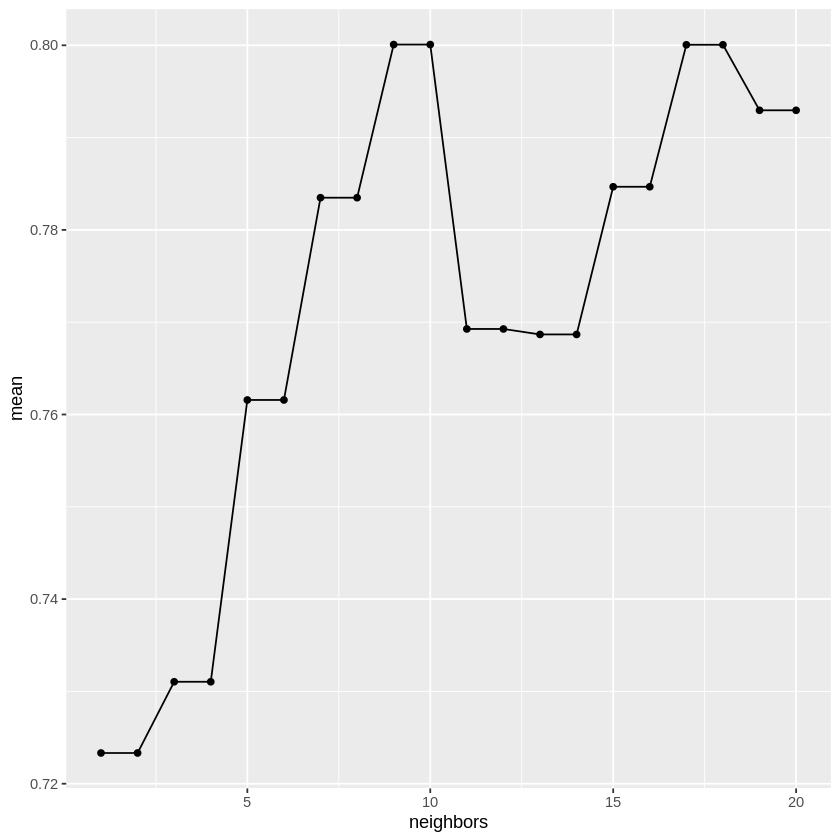

In [18]:
set.seed(2000) 

vfold <- vfold_cv (data_training, v=5, strata= presence_of_heart_disease)

grid_vals <- tibble(neighbors = seq(from=1, to = 20))

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine ("kknn") |>
set_mode ("classification")

recipe <- recipe(presence_of_heart_disease ~ age +max_heart_rate+oldpeak+number_of_vessels_colored, data= data_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

fruit_fit_results <- workflow() |>
add_recipe(recipe) |>
add_model(spec) |>
tune_grid(resamples = vfold, grid=grid_vals) |>
collect_metrics() |>
filter (.metric == "accuracy") |>
arrange(mean)
fruit_fit_results

graph <- fruit_fit_results |>
ggplot (aes (x= neighbors, y=mean)) +
geom_point () +
geom_line ()
graph

In [22]:
set.seed(2000) 

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
set_engine ("kknn") |>
set_mode ("classification")

fit <- workflow() |>
add_recipe(recipe) |>
add_model(spec) |>
fit(data=data_training) 
fit


predict <- predict(fit, data_testing) |>
bind_cols(data_testing)|>
metrics(truth = presence_of_heart_disease, estimate = .pred_class) |>
filter (.metric == "accuracy")
predict

Warning message:
“Column(s) have zero variance so scaling cannot be used: `number_of_vessels_colored`. Consider using `step_zv()` to remove those columns before normalizing”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2153846
Best kernel: rectangular
Best k: 10

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7777778
